In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
from torch import nn
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import radius_graph, knn_graph

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
with h5py.File('data/train_xyze_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['data']
    data = []
    for i, event in enumerate(label_events):
        pts = f['data'][i].reshape(-1,4)
        data.append(pts)

In [4]:
# Open the labels file
with h5py.File('data/train_label_1e4.h5', 'r') as f:
    # Access the dataset
    label_events = f['labels']
    
    labels = []

    for i, event in enumerate(label_events):
        labels.append(event)

In [5]:
# Define the training truth labels
# 2 is the label for Michel electrons
truth = [(event_labels == 2).astype(np.int32) for event_labels in labels]
# val_truth = torch.tensor([x for x_event in val_truth for x in x_event]).to(device)

In [6]:
train_data = []
val_data = []
test_data = []

# Iterate over all the events and create sparse tensors that are then merged
# For each input_coords, add another column for the batch index, which is just the index of the event
for i, (event_coords, input_labels) in enumerate(zip(tqdm(data), truth)):
    # Use the first three columns as coordinates
    input_coords = torch.tensor(event_coords[:, :3], dtype=torch.int32)  
    # Use the fourth column as features
    input_features = torch.tensor(event_coords[:, 3], dtype=torch.float32).unsqueeze(1)
    
    edge_index = knn_graph(input_coords, k=4, loop=False)
    # Compute the edge attributes (distances)
    row, col = edge_index
    edge_attr = input_coords[row] - input_coords[col]
    edge_attr = torch.norm(edge_attr.to(torch.float32), p=2, dim=1).view(-1, 1)  # Reshape to [num_edges, 1]
    # edge_index = radius_graph(input_coords, r=3.0, loop=False)
    
    event_data = Data(
        x=input_features,
        edge_index=edge_index,
        y=torch.tensor(input_labels, dtype=torch.float32),
        edge_attr=edge_attr,
    )

    if i < 500:
        val_data.append(event_data)
        continue
    if i < 1000:
        test_data.append(event_data)
        continue

    train_data.append(event_data)

100%|██████████| 10000/10000 [02:31<00:00, 65.84it/s]


In [7]:
with open('data/gnn_val_data_4.pkl', 'wb') as f:
    pickle.dump(val_data, f)

In [8]:
with open('data/gnn_test_data_4.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [9]:
with open('data/gnn_train_data_4a.pkl', 'wb') as f:
    pickle.dump(train_data[:4500], f)
with open('data/gnn_train_data_4b.pkl', 'wb') as f:
    pickle.dump(train_data[4500:], f)

In [ ]:
with open('data/gnn_train_data_4a.pkl', 'rb') as f:
    train_data_a = pickle.load(f)
with open('data/gnn_train_data_4b.pkl', 'rb') as f:
    train_data_b = pickle.load(f)

train_data = train_data_a + train_data_b

# with open('data/gnn_train_data_1.pkl', 'rb') as f:
#     train_data1 = pickle.load(f)
with open('data/gnn_val_data_4.pkl', 'rb') as f:
    val_data = pickle.load(f)

len(train_data), len(val_data)#, len(test_data)

(9000, 500)

(array([ 18.,  73., 176., 358., 419., 545., 624., 642., 670., 668., 512.,
        497., 399., 329., 318., 263., 206., 185., 165., 149., 158., 143.,
        143., 106., 130., 100., 115., 103., 108.,  96., 101.,  72.,  61.,
         63.,  44.,  54.,  54.,  26.,  27.,  25.,  13.,  13.,   7.,   7.,
          8.,   5.,   0.,   0.,   1.,   1.]),
 array([  120.  ,   441.94,   763.88,  1085.82,  1407.76,  1729.7 ,
         2051.64,  2373.58,  2695.52,  3017.46,  3339.4 ,  3661.34,
         3983.28,  4305.22,  4627.16,  4949.1 ,  5271.04,  5592.98,
         5914.92,  6236.86,  6558.8 ,  6880.74,  7202.68,  7524.62,
         7846.56,  8168.5 ,  8490.44,  8812.38,  9134.32,  9456.26,
         9778.2 , 10100.14, 10422.08, 10744.02, 11065.96, 11387.9 ,
        11709.84, 12031.78, 12353.72, 12675.66, 12997.6 , 13319.54,
        13641.48, 13963.42, 14285.36, 14607.3 , 14929.24, 15251.18,
        15573.12, 15895.06, 16217.  ]),
 <BarContainer object of 50 artists>)

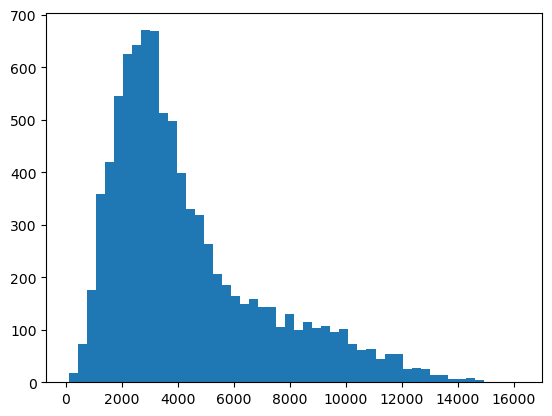

In [4]:
plt.hist([t.y.shape[0] for t in train_data], bins=50)

In [81]:
# Calculate average number of connections per node
avg_connections = np.mean([t.edge_index.shape[1] / t.x.shape[0] for t in train_data])
print(f"Average number of connections per node: {avg_connections:.2f}")

Average number of connections per node: 4.00


In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [6]:
train_n_nodes = sum(len(d.x) for d in train_loader)
val_n_nodes = sum(len(d.x) for d in val_loader)
print(f"Train nodes: {train_n_nodes}, Val nodes: {val_n_nodes}")

Train nodes: 39427959, Val nodes: 2187515


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, heads=1):
        super(GNN, self).__init__()
        self.conv1 = GATConv(in_channels=1, out_channels=hidden_dim, heads=heads, edge_dim=1)
        self.conv2 = GATConv(in_channels=hidden_dim * heads, out_channels=hidden_dim, heads=1, edge_dim=1)
        self.conv3 = GATConv(in_channels=hidden_dim, out_channels=output_dim, heads=1, concat=False, edge_dim=1)

    def forward(self, x, edge_index, edge_attr):
        # TODO try skip connections
        # TODO add more layers and hidden channels
        # TODO add weights
        # Layer 1
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        # Layer 2
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        # Output layer
        x = self.conv3(x, edge_index, edge_attr)
        # Normalization
        # if self.training:
        x = F.sigmoid(x)
        return x

# Initialize model
model = GNN(hidden_dim=4, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-5)

train_loss_list = []
val_loss_list = []

# Training loop with validation
best_val_f1 = 0.0
for epoch in tqdm(range(100)):
    # Training
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model((batch.x / 20.).to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
        # weight = batch.y.unsqueeze(1) + 0.1
        loss = F.binary_cross_entropy(out, batch.y.unsqueeze(1).to(device), reduction="sum")
        # loss = (loss * weight).sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Divide by the total number of nodes in all batches
    train_loss /= train_n_nodes
    
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    preds = []

    with torch.no_grad():
        for batch in val_loader:
            # weight = batch.y.unsqueeze(1) + 0.1
            out = model((batch.x / 20.).to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
            loss = F.binary_cross_entropy(out, batch.y.unsqueeze(1).to(device), reduction="sum")
            # loss = (loss * weight).sum()
            preds.append(out)
            val_loss += loss.item()

    val_loss /= val_n_nodes
    val_loss_list.append(val_loss)

    # print(
    #     f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, "
    #     f"Val Loss: {val_loss:.4f}, "
    # )

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pt")
    

 22%|██▏       | 22/100 [04:07<14:30, 11.17s/it]

In [17]:
plt.rcParams.update({'font.size': 14})

Best epoch: 29, Best Val Loss: 0.08414421943963812


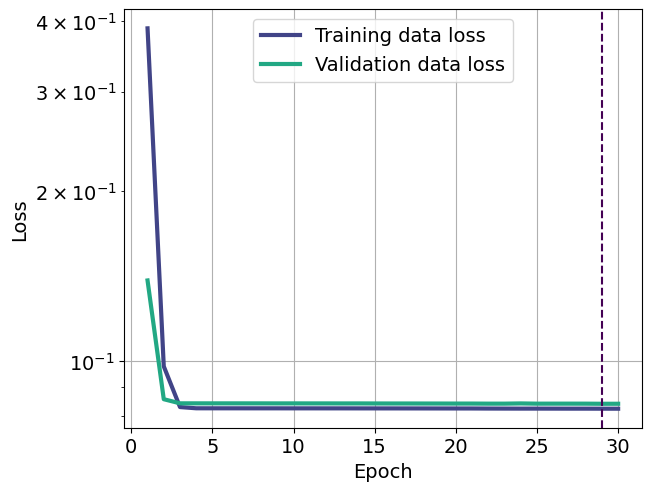

In [ ]:
fig, ax = plt.subplots(layout='constrained')
# Plot the training and validation loss
ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label='Training data loss', lw=3, color=plt.cm.viridis(0.2))
ax.plot(range(1, len(train_loss_list)+1), val_loss_list, label='Validation data loss', lw=3, color=plt.cm.viridis(0.6))
ax.set(xlabel='Epoch', ylabel='Loss', yscale='log')
ax.legend()
ax.grid()

# Get the epoch with the lowest validation loss
best_epoch = np.argmin(val_loss_list) + 1
print(f"Best epoch: {best_epoch}, Best Val Loss: {min(val_loss_list)}")
ax.axvline(best_epoch, color=plt.cm.viridis(0.), linestyle='--', label=f'Best epoch: {best_epoch}')
fig.savefig("training_validation_loss.svg")

In [ ]:
# Save training and test loss
with open("train_loss.txt", "w") as f:
    for line in train_loss_list:
        f.write(f"{line}\n")

with open("val_loss.txt", "w") as f:
    for line in val_loss_list:
        f.write(f"{line}\n")

In [10]:
model = GNN(hidden_dim=4, output_dim=1).to(device)
# Load model
model.load_state_dict(torch.load("model_epoch_20.pt"))

<All keys matched successfully>

In [ ]:
model.eval()
preds = []

with torch.no_grad():
    for batch in val_loader:
        out = model((batch.x / 20.).to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
        preds.append(out)


[Text(0.5, 0, 'Predicted Probability'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Distribution of GNN predictions'),
 None]

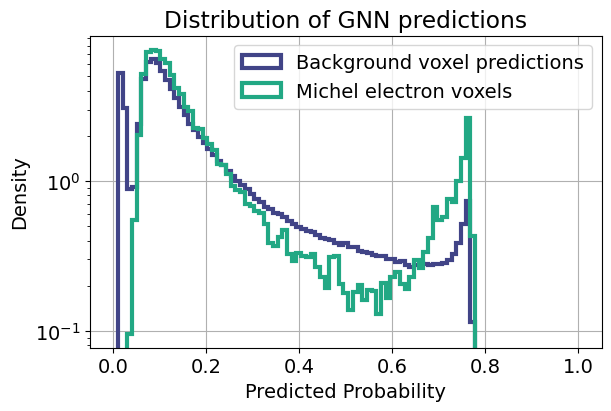

In [63]:
preds_only_truth = torch.cat([batch[batch2.y == 1] for batch2, batch in zip(val_loader, preds)]).squeeze()
preds_only_bkg = torch.cat([batch[batch2.y == 0] for batch2, batch in zip(val_loader, preds)]).squeeze()
# plot the distribution of predictions

bins = np.linspace(0., 1., 100)

fig, ax = plt.subplots(figsize=(6, 4), 
                       layout="constrained")
ax.hist(
    preds_only_bkg.cpu().numpy(), 
    density=True, bins=bins, label="Background voxel predictions", color=plt.cm.viridis(0.2), linewidth=3, histtype="step", 
)
# plot the distribution of predictions for only nodes with label 1
ax.hist(
    preds_only_truth.cpu().numpy(), 
    density=True, bins=bins, label="Michel electron voxels", color=plt.cm.viridis(0.6), histtype="step", linewidth=3,
)

ax.legend()
ax.grid()
# ax.xlim(0, 0.1)
ax.set(
    xlabel='Predicted Probability', ylabel='Density', title='Distribution of GNN predictions', yscale="log", 
    # xlim=(0.013, 0.0825)
)

In [65]:
preds_flat = torch.cat(preds).squeeze()

# Plot the F1 score as a function of the cut value
cut_values = np.linspace(0., 1., 20)
f1_scores = []
for cut in cut_values:
    preds_cut = preds_flat > cut
    f1 = f1_score(
        torch.cat([batch.y for batch in val_loader]).cpu().numpy(),
        preds_cut.cpu().numpy(),
        # average='macro'
    )
    f1_scores.append(f1)

Best cut value: 0.6842105263157894, Best F1 score: 0.05821787901230108


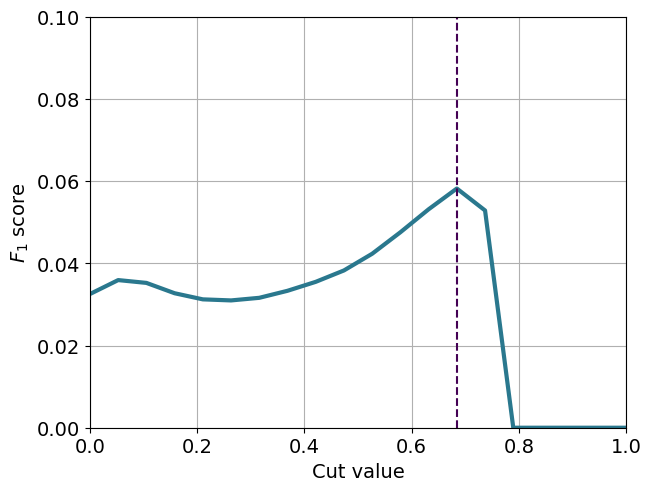

In [68]:
fig, ax = plt.subplots(layout="constrained")
ax.plot(cut_values, f1_scores, color=plt.cm.viridis(0.4), lw=3)
ax.set(xlabel='Cut value', ylabel='$F_1$ score', ylim=(0, 0.1), xlim=(0, 1.))
best_cut_value = cut_values[np.argmax(f1_scores)]
print(f"Best cut value: {best_cut_value}, Best F1 score: {max(f1_scores)}")
ax.axvline(best_cut_value, color=plt.cm.viridis(0.), linestyle='--', label=f'Best cut value: {best_cut_value:.4f}')

ax.grid()

# fig.savefig("f1_score_vs_cut.svg")

In [26]:
with open('data/gnn_test_data_4.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [29]:
model.eval()
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
preds = []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device))
        preds.append(out)

preds_flat = F.sigmoid(torch.cat(preds).squeeze())
f1_score(torch.cat([batch.y for batch in test_loader]).cpu().numpy(), (preds_flat > best_cut_value).cpu().numpy())

0.08114609220301142

In [ ]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GNN(input_dim=1, hidden_dim=4, output_dim=1)
model.load_state_dict(torch.load("model_epoch_5.pt"))